<a href="https://www.kaggle.com/code/zjzhao1002/nlp-disaster-tweets?scriptVersionId=193146477" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This notebook builds a Long Short-Term Memory (LSTM) model to predict which Tweets are about real disasters and which ones are not. The vectorization of text is done by GloVe Embeddings.

# 1. Data Loading and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print(df_train.head())
print(df_test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
df_train = df_train.drop(['id', 'keyword', 'location'], axis=1)
df_test = df_test.drop(['id', 'keyword', 'location'], axis=1)
print(df_train.head())
print(df_test.head())

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1
                                                text
0                 Just happened a terrible car crash
1  Heard about #earthquake is different cities, s...
2  there is a forest fire at spot pond, geese are...
3           Apocalypse lighting. #Spokane #wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
target_counts = df_train['target'].value_counts()
print(target_counts)

target
0    4342
1    3271
Name: count, dtype: int64


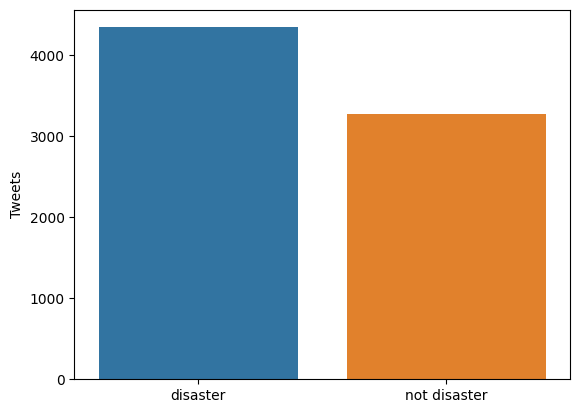

In [5]:
sns.barplot(x=target_counts.index, y=target_counts)
plt.ylabel('Tweets')
plt.xlabel('')
plt.xticks([0,1], ['disaster', 'not disaster'])
plt.show()

In [6]:
df_train['length'] = df_train['text'].apply(lambda x : len(x))
df_test['length'] = df_test['text'].apply(lambda x : len(x))
print(df_train.head())
print(df_test.head())

                                                text  target  length
0  Our Deeds are the Reason of this #earthquake M...       1      69
1             Forest fire near La Ronge Sask. Canada       1      38
2  All residents asked to 'shelter in place' are ...       1     133
3  13,000 people receive #wildfires evacuation or...       1      65
4  Just got sent this photo from Ruby #Alaska as ...       1      88
                                                text  length
0                 Just happened a terrible car crash      34
1  Heard about #earthquake is different cities, s...      64
2  there is a forest fire at spot pond, geese are...      96
3           Apocalypse lighting. #Spokane #wildfires      40
4      Typhoon Soudelor kills 28 in China and Taiwan      45


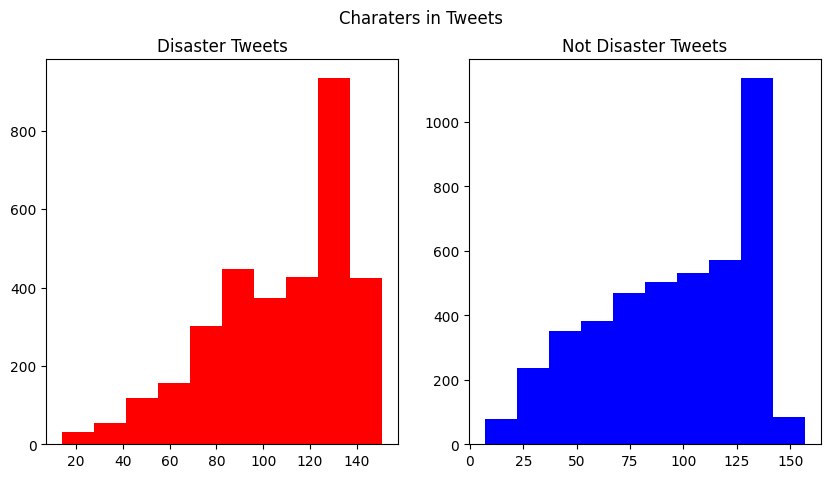

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(df_train[df_train['target']==1]['length'], color='red')
ax1.set_title('Disaster Tweets')
ax2.hist(df_train[df_train['target']==0]['length'], color='blue')
ax2.set_title('Not Disaster Tweets')
fig.suptitle('Charaters in Tweets')
plt.show()

In [8]:
df_train['word_count'] = df_train['text'].apply(lambda x : len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x : len(str(x).split()))
print(df_train.head())
print(df_test.head())

                                                text  target  length  \
0  Our Deeds are the Reason of this #earthquake M...       1      69   
1             Forest fire near La Ronge Sask. Canada       1      38   
2  All residents asked to 'shelter in place' are ...       1     133   
3  13,000 people receive #wildfires evacuation or...       1      65   
4  Just got sent this photo from Ruby #Alaska as ...       1      88   

   word_count  
0          13  
1           7  
2          22  
3           8  
4          16  
                                                text  length  word_count
0                 Just happened a terrible car crash      34           6
1  Heard about #earthquake is different cities, s...      64           9
2  there is a forest fire at spot pond, geese are...      96          19
3           Apocalypse lighting. #Spokane #wildfires      40           4
4      Typhoon Soudelor kills 28 in China and Taiwan      45           8


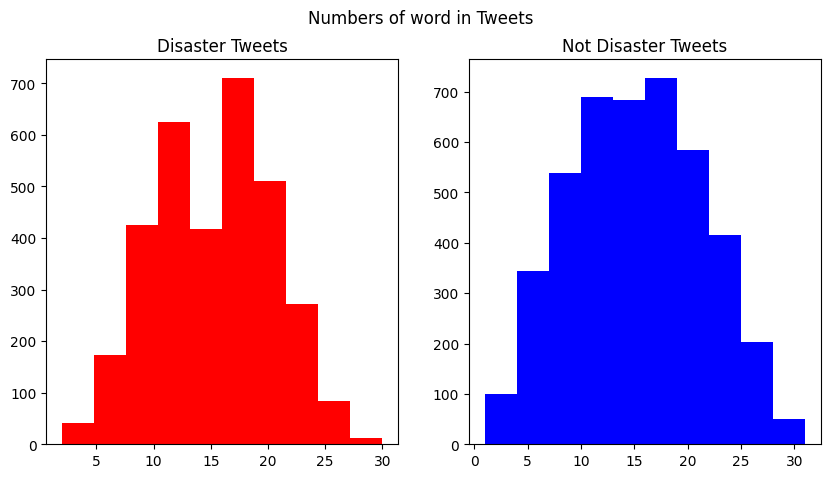

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(df_train[df_train['target']==1]['word_count'], color='red')
ax1.set_title('Disaster Tweets')
ax2.hist(df_train[df_train['target']==0]['word_count'], color='blue')
ax2.set_title('Not Disaster Tweets')
fig.suptitle('Numbers of word in Tweets')
plt.show()

# 2. Data Cleaning and Preprocessing

The first thing we have to do is cleaning data. We want to remove text in square brackets, links, punctuation, words containing numbers, and emojis. 

The second step is defining the stop words. Stop words should be removed, too.

The last step is stemming.

In [10]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Defining the stopwords and removing them
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

#Words stemming
stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

#Function gets everything together
def preprocess_text(text):
    text = clean_text(text)
    text = remove_emoji(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    return text

In [21]:
df_train['clean_text'] = df_train['text'].apply(preprocess_text)
df_test['clean_text'] = df_test['text'].apply(preprocess_text)
# print(df_train['clean_text'].str.len())

The following codes give us a token visualisation. We can see which words appear frequently.

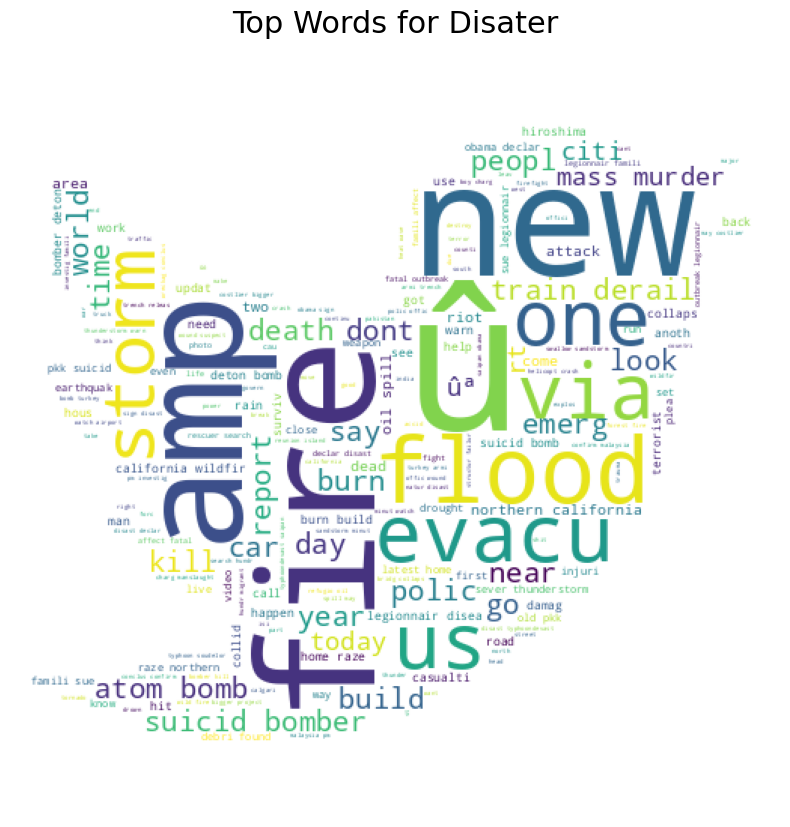

In [12]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df_train.loc[df_train['target'] == 1, 'clean_text']))
plt.figure(figsize=(18,10))
plt.title('Top Words for Disater', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

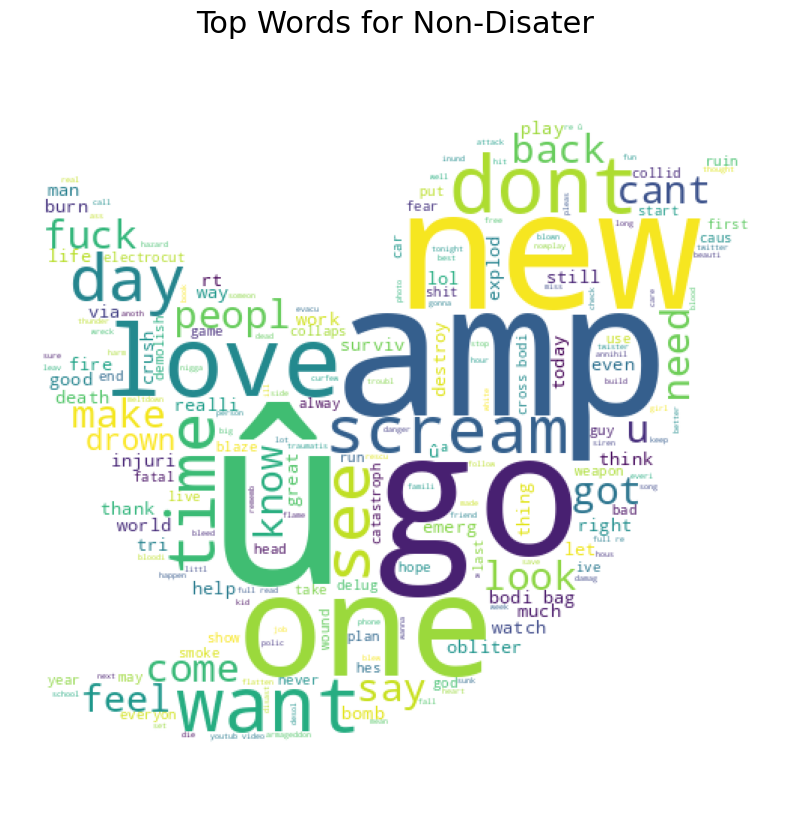

In [13]:
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df_train.loc[df_train['target'] == 0, 'clean_text']))
plt.figure(figsize=(18,10))
plt.title('Top Words for Non-Disater', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# 3. Model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [22]:
X_train = df_train['clean_text']
X_test = df_test['clean_text']
y_train = df_train['target']

The following codes perform a tokenization, a process that splits the text into sentences. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing. 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [23]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
vocab_length = len(word_tokenizer.word_index) + 1
print(vocab_length)

13694


In [24]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(X_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

padded_sentences = pad_sequences(
    embed(X_train), 
    length_long_sentence, 
    padding='post'
)

test_sentences = pad_sequences(
    embed(X_test), 
    length_long_sentence,
    padding='post'
)

In [25]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/kaggle/input/glove-file/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.2687      0.81708002  0.69896001 ... -0.40110001  0.74656999
   0.31121999]
 [-0.26872    -0.15542001 -0.23565    ...  0.49344     0.72114003
  -0.041749  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.19814    -0.33517    -0.13950001 ... -0.070356   -0.18391
   0.62439001]
 [-0.34132001  0.26423001  0.47813001 ... -0.92395002  0.48275
   0.52947998]]


Explanation of LSTM from wikipedia: 
> Long short-term memory (LSTM) is a type of recurrent neural network (RNN) aimed at dealing with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. It aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory". 

In [27]:
from sklearn.model_selection import train_test_split
text_train, text_val, target_train, target_val = train_test_split(
    padded_sentences, 
    y_train, 
    test_size=0.25
)

In [30]:
def glove_LSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix]))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [31]:
model = glove_LSTM()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,369,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,400 (5.22 MB)

 Trainable params: 1,369,400 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    text_train, 
    target_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [text_val, target_val],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5312 - loss: 0.9062
Epoch 1: val_loss improved from inf to 0.67363, saving model to model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5316 - loss: 0.9046 - val_accuracy: 0.7332 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 2/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6256 - loss: 0.6649
Epoch 2: val_loss improved from 0.67363 to 0.59828, saving model to model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6257 - loss: 0.6647 - val_accuracy: 0.7805 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 3/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6963 - loss: 0.6079
Epoch 3: val_loss improved from 0.59828 to 0.50696, saving model to model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6964 - loss: 0.6078 - val_accuracy: 0.7852 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 4/7
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7420 - loss: 

In [35]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

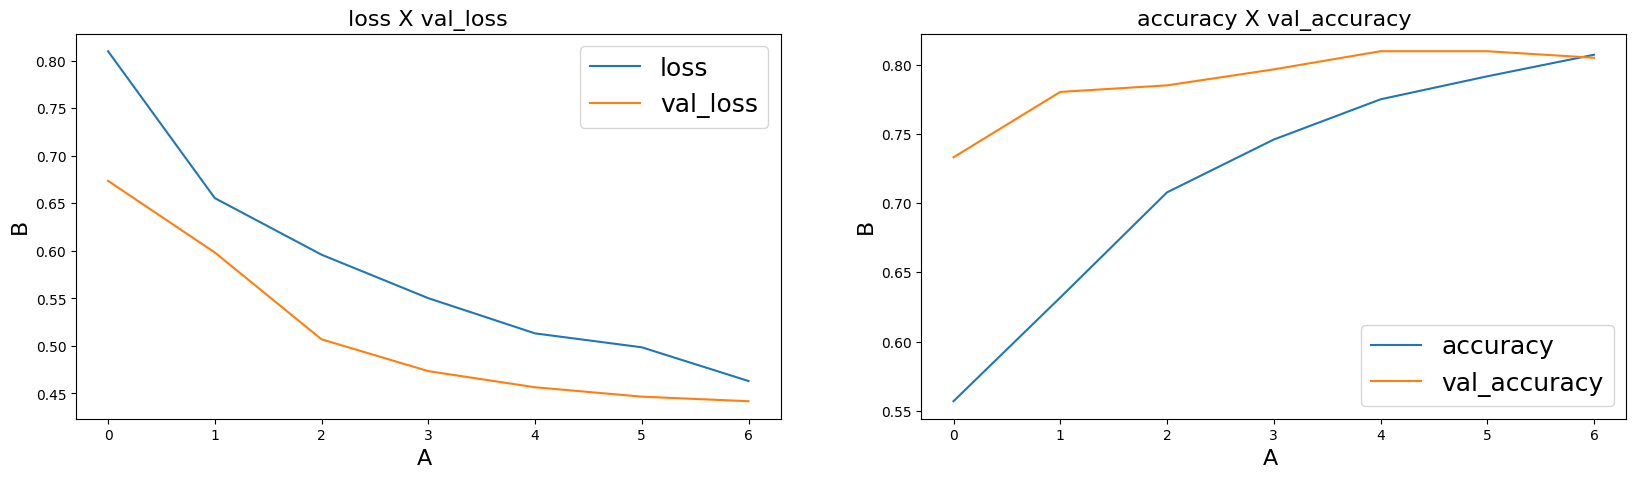

In [36]:
plot(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [38]:
loss, accuracy = model.evaluate(text_val, target_val)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8085 - loss: 0.4316
Loss:  0.4418432414531708
Accuracy:  0.8051470518112183


In [44]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [55]:
preds = (model.predict(text_val) > 0.5).astype("int32")
print(preds)
metrics(preds, target_val)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]
F1-score:  0.7241635687732343
Precision:  0.6049689440993788
Recall:  0.9018518518518519
Acuracy:  0.8051470588235294
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1364
           1       0.60      0.90      0.72       540

    accuracy                           0.81      1904
   macro avg       0.78      0.83      0.79      1904
weighted avg       0.85      0.81      0.81      1904



It seems that this model has a good performance. Finally, let's make a submission.

In [58]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission["target"] = (model.predict(test_sentences) > 0.5).astype("int32")
print(submission)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
         id  target
0         0       0
1         2       0
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       0
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]


In [59]:
submission.to_csv("submission.csv", index=False)

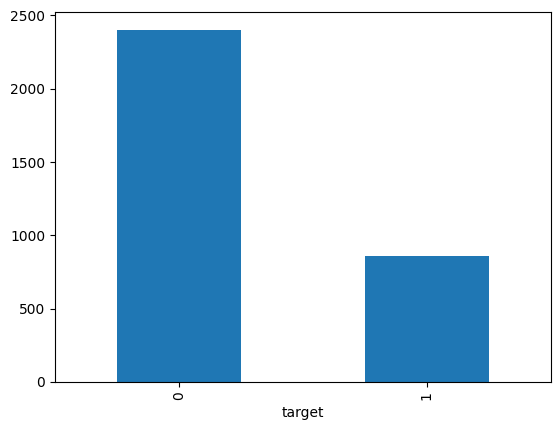

In [60]:
submission.target.value_counts().plot.bar();